<a href="https://colab.research.google.com/github/JCKaren/Proyecto-Modelos/blob/main/04%20-%20preprocesado%20entrega%20final%20con%20XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


# Importaciones e Instalaciones necesarias.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Clase para la generación del modelo

La clase **StudentPerformanceXGBoostClassifier** está diseñada para predecir el rendimiento académico de los estudiantes a partir de diversos datos demográficos y socioeconómicos. Utiliza el modelo de clasificación **XGBooost** para realizar las predicciones. La clase implementa un proceso completo de preprocesamiento de datos, que incluye la creación de características a partir de la educación de los padres, el estrato socioeconómico, la matrícula universitaria y otros factores relacionados con los programas académicos y los departamentos de los estudiantes. Además, la clase incluye técnicas de codificación dirigida (target encoding) para mejorar la representación de categorías en las variables. El modelo entrenado se evalúa a través de métricas de clasificación, como el reporte de clasificación y la matriz de confusión, y proporciona una visualización de la importancia de las características utilizadas en el modelo.

In [ ]:
class StudentPerformanceXGBoostClassifier:
    """
    Clasificador de rendimiento académico utilizando XGBoost.
    Esta clase implementa un modelo de clasificación multiclase para predecir el rendimiento
    académico de estudiantes basado en características socioeconómicas y académicas.
    """
    def __init__(self):
        self.model = None
        self.label_encoders = {}
        self.performance_encoder = LabelEncoder()
        self.training_columns_ = None

    def _preprocess_dataframe(self, df, training=False):
        """
        Función centralizada para preprocesar un DataFrame (train o test).
        """
        df_processed = df.copy()

        # --- 1. FEATURE ENGINEERING ---
        # PERIODO
        if 'PERIODO' in df_processed.columns:
            df_processed['AÑO'] = pd.to_numeric(df_processed['PERIODO'].astype(str).str[:4])
            df_processed['BIMESTRE'] = pd.to_numeric(df_processed['PERIODO'].astype(str).str[4])
            df_processed.drop(columns=["PERIODO"], inplace=True)

        # EDUCACIÓN PADRES
        education_mapping = {
            'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
            'Postgrado': 9, 'No sabe': 4, 'No Aplica': 4, 'No reporta': 4
        }
        df_processed['FAMI_EDUCACIONPADRE'] = df_processed['FAMI_EDUCACIONPADRE'].fillna('No reporta').map(education_mapping)
        df_processed['FAMI_EDUCACIONMADRE'] = df_processed['FAMI_EDUCACIONMADRE'].fillna('No reporta').map(education_mapping)
        df_processed['FAMI_EDUCACION_PROMEDIO'] = (df_processed['FAMI_EDUCACIONPADRE'] + df_processed['FAMI_EDUCACIONMADRE']) / 2
        df_processed['FAMI_EDUCACION_DIFERENCIA'] = abs(df_processed['FAMI_EDUCACIONPADRE'] - df_processed['FAMI_EDUCACIONMADRE'])

        # ECONÓMICO
        estrato_mapping = {
            'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3, 'Estrato 4': 4,
            'Estrato 5': 5, 'Estrato 6': 6, 'Sin Estrato': 0, 'No reporta': 3
        }
        matricula_mapping = {
            'Menos de 500 mil': 0, 'Entre 500 mil y menos de 1 millón': 1,
            'Entre 1 millón y menos de 2.5 millones': 2, 'Entre 2.5 millones y menos de 4 millones': 3,
            'Entre 4 millones y menos de 5.5 millones': 4, 'Entre 5.5 millones y menos de 7 millones': 5,
            'Más de 7 millones': 6, 'No pagó matrícula': 0, 'No reporta': 3
        }
        df_processed['FAMI_ESTRATOVIVIENDA'] = df_processed['FAMI_ESTRATOVIVIENDA'].fillna('No reporta').map(estrato_mapping)
        df_processed['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_processed['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('No reporta').map(matricula_mapping)
        df_processed['FAMI_TIENEINTERNET'] = (df_processed['FAMI_TIENEINTERNET'].fillna('No') == 'Si').astype(int)
        df_processed['SCORE_SOCIOECONOMICO'] = (df_processed['FAMI_ESTRATOVIVIENDA'] * 0.4 + df_processed['ESTU_VALORMATRICULAUNIVERSIDAD'] * 0.4 + df_processed['FAMI_TIENEINTERNET'] * 0.2)

        # --- 2. CODIFICACIÓN DE CATEGÓRICAS RESTANTES ---
        categorical_cols = df_processed.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            df_processed[col] = df_processed[col].fillna('No reporta')
            if training:
                le = LabelEncoder()
                # --- CORRECCIÓN CLAVE ---
                # Obtener todas las categorías únicas y añadir 'No reporta'
                # para asegurar que el encoder lo conozca.
                unique_values = df_processed[col].unique().tolist()
                if 'No reporta' not in unique_values:
                    unique_values.append('No reporta')
                le.fit(unique_values)
                self.label_encoders[col] = le

            # La transformación ahora es segura tanto para train como para test
            le = self.label_encoders[col]
            known_classes = set(le.classes_)
            # Reemplazar valores no conocidos con 'No reporta' antes de transformar
            df_processed[col] = df_processed[col].apply(lambda x: x if x in known_classes else 'No reporta')
            df_processed[col] = le.transform(df_processed[col])

        # Eliminar columnas con coeficientes si existen
        coef_cols_to_drop = ['coef_1', 'coef_2', 'coef_3', 'coef_4']
        df_processed.drop(columns=[c for c in coef_cols_to_drop if c in df_processed.columns], inplace=True)

        return df_processed

    def preprocess_and_split_data(self, data):
        X = data.drop(columns=['RENDIMIENTO_GLOBAL'])
        y = data['RENDIMIENTO_GLOBAL']

        X_processed = self._preprocess_dataframe(X, training=True)
        y_encoded = self.performance_encoder.fit_transform(y)

        # Guardar las columnas de entrenamiento para la predicción
        self.training_columns_ = X_processed.columns.drop('ID', errors='ignore')

        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Añadir esta línea para que classifier.df_train.head() funcione (Opción 2 de la pregunta anterior)
        self.df_train = X_train.copy()

        return X_train, X_test, y_train, y_test

    def train_model(self, X_train, y_train, X_test, y_test):
        X_train_no_id = X_train.drop(columns=['ID'], errors='ignore')
        X_test_no_id = X_test.drop(columns=['ID'], errors='ignore')

        self.model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.performance_encoder.classes_),
            eval_metric='mlogloss',
            learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            n_estimators=2000, random_state=42,
            early_stopping_rounds=50,
            tree_method='gpu_hist', enable_categorical=False
        )

        self.model.fit(
            X_train_no_id, y_train,
            eval_set=[(X_test_no_id, y_test)],
            verbose=100
        )
        self.feature_importance = self.model.feature_importances_

    def evaluate_model(self, X_test, y_test):
        X_test_no_id = X_test.drop(columns=['ID'], errors='ignore')
        predictions_encoded = self.model.predict(X_test_no_id)

        predictions_original = self.performance_encoder.inverse_transform(predictions_encoded)
        y_test_original = self.performance_encoder.inverse_transform(y_test)

        report = classification_report(y_test_original, predictions_original, zero_division=0)
        cm = confusion_matrix(y_test_original, predictions_original, labels=self.performance_encoder.classes_)

        return report, cm

    def plot_feature_importance(self):
        if self.feature_importance is None: return
        importance_df = pd.DataFrame({
            'feature': self.training_columns_,
            'importance': self.feature_importance
        }).sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title('Top 20 - Feature Importance (XGBoost)')
        plt.tight_layout()
        plt.show()

    def predict(self, X_new):
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado.")

        X_prepared = self._preprocess_dataframe(X_new, training=False)

        # Alinear columnas con las del entrenamiento
        X_prepared = X_prepared.reindex(columns=self.training_columns_, fill_value=0)

        predictions_encoded = self.model.predict(X_prepared)
        return self.performance_encoder.inverse_transform(predictions_encoded)

    def save_predictions(self, X, output_file):
        predictions = self.predict(X)
        results = pd.DataFrame({'ID': X['ID'], 'RENDIMIENTO_GLOBAL': predictions})
        results.to_csv(output_file, index=False)
        print(f"Predicciones guardadas en '{output_file}'")
        return results

# Uso de la Clase

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
# Se inicializa un objeto de la clase y empezamos el preprocesado
classifier = StudentPerformanceXGBoostClassifier()

# Llamamos al método con su nuevo nombre: preprocess_and_split_data
X_train, X_test, y_train, y_test = classifier.preprocess_and_split_data(data)

print("Preprocesamiento y división de datos completados.")
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)

Preprocesamiento y división de datos completados.
Dimensiones de X_train: (554000, 20)
Dimensiones de X_test: (138500, 20)


Forma final de los datos para entrenar

In [ ]:
classifier.df_train.head()

,ID,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,AÑO,BIMESTRE,FAMI_EDUCACION_PROMEDIO,FAMI_EDUCACION_DIFERENCIA,SCORE_SOCIOECONOMICO
503557,403485,229,4,2,4,2,1,3,2,2,0,2,2,2,3,2018,3,3.0,0,1.8
145156,823409,317,4,2,5,3,0,4,1,1,0,0,1,1,4,2021,2,4.0,0,2.0
224208,683098,410,4,4,2,2,1,4,2,2,0,0,2,2,4,2020,3,4.0,0,2.6
103009,263563,94,3,1,1,3,1,4,2,0,0,2,2,2,4,2018,3,4.0,0,1.8
273179,376561,249,10,3,0,1,1,1,2,0,0,0,2,2,4,2018,3,2.5,3,1.8


In [ ]:
# Se empieza el entrenamiento
# Se empieza el entrenamiento, pasando también los datos de validación
print("Iniciando el entrenamiento del modelo XGBoost...")
classifier.train_model(X_train, y_train, X_test, y_test)
print("Entrenamiento completado.")

Iniciando el entrenamiento del modelo XGBoost...
[0]	validation_0-mlogloss:1.37910


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-mlogloss:1.23579
[200]	validation_0-mlogloss:1.21689
[300]	validation_0-mlogloss:1.20898
[400]	validation_0-mlogloss:1.20429
[500]	validation_0-mlogloss:1.20143
[600]	validation_0-mlogloss:1.19954
[700]	validation_0-mlogloss:1.19807
[800]	validation_0-mlogloss:1.19706
[900]	validation_0-mlogloss:1.19634
[1000]	validation_0-mlogloss:1.19573
[1100]	validation_0-mlogloss:1.19535
[1200]	validation_0-mlogloss:1.19509
[1300]	validation_0-mlogloss:1.19498
[1400]	validation_0-mlogloss:1.19484
[1500]	validation_0-mlogloss:1.19482
[1527]	validation_0-mlogloss:1.19482
Entrenamiento completado.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


# Evaluación del Modelo

Una vez realizada la evaluación del modelo, nos podemos dar cuenta que a pesar de la ingeniería de características utilizada aún existe confusión en el mismo para la predicción de las clases medio-alto y medio-bajo, el modelo se desempeña mejor en las clases extremas. Lo cual también se valida en la matrix de confusión.

Nota:Este modelo tuvo un desempeño menor con respecto al CatBoost a pesar de tener el mismo preprocesado (casi idéntico, la diferencia radica que aquí todas las features fueron convertidas a número antes del entrenamiento)


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.56      0.63      0.59     35124
        bajo       0.47      0.56      0.51     34597
  medio-alto       0.33      0.28      0.30     34324
  medio-bajo       0.34      0.28      0.30     34455

    accuracy                           0.44    138500
   macro avg       0.42      0.44      0.43    138500
weighted avg       0.42      0.44      0.43    138500


Matriz de Confusión:


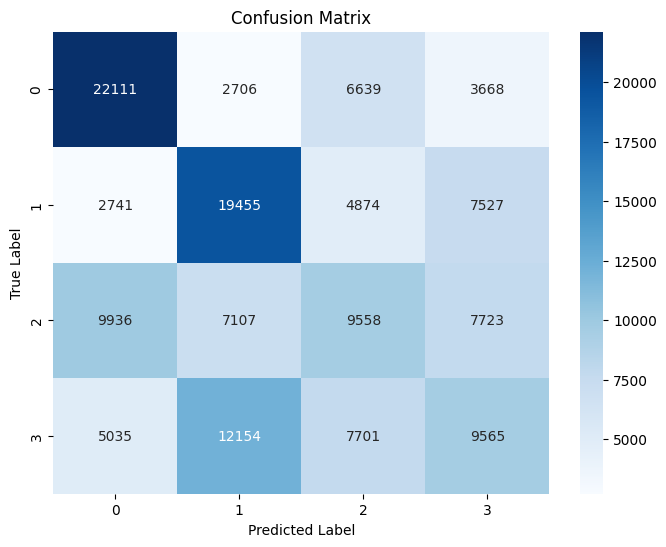

In [ ]:
report, cm = classifier.evaluate_model(X_test, y_test)

print("\nReporte de Clasificación:")
print(report)
print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Prueba con los datos de envío

In [ ]:
X_test = pd.read_csv('test.csv')

In [ ]:
X_test.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286


In [ ]:
# Hacer y guardar predicciones
results = classifier.save_predictions(X_test, 'my_submission.csv')

Predicciones guardadas en 'my_submission.csv'


In [ ]:
results

,ID,RENDIMIENTO_GLOBAL
0,550236,medio-alto
1,98545,medio-bajo
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto
